In [ ]:
pip install keras-tuner

     |████████████████████████████████| 71kB 3.5MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=c5b7e8f9ecb9963482efb0a377c8fab4364d1fe4d1f42a5d27726488ed185ea7
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=e97f11b0fd78ca5a95130b4012d204ade9b66a74fc63b1127344bb6551613b03
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import zipfile
import os
import cv2
import shutil

import numpy as np
import pandas as pd
from datetime import datetime as dt
from matplotlib import pyplot as plt
import json
import re
import pickle

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image 
from tensorflow.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras import utils
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model

import kerastuner

In [ ]:
shutil.copyfile('/content/gdrive/MyDrive/DSIM/image_classification/archive.zip', 'archive.zip')

image_data = zipfile.ZipFile('archive.zip')
image_data.extractall()
image_data.close()

In [ ]:
backend.set_floatx('float16')

#Funzioni e classi

In [ ]:
def build_model(pre_trained, cut, optimizer, regularization = False):
  
  # elenco dei nomi dei layers
  layer_names = [layer.name for layer in pre_trained.layers]
  layer_idx = layer_names.index(cut) + 1
  
  # ricostruzione architettura dal primo layer non congelato (layer_idx)
  inputs = layers.Input(X_train.shape[1:])
  x = inputs
  for layer in pre_trained.layers[layer_idx:]:
    x = layer (x)
  
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(3, activation='softmax')(x)

  model = Model(inputs = inputs, outputs = x)
  
  # regolarizzazione di tutti i layer convoluzionali
  if regularization:
    for layer in model.layers:
      if isinstance(layer, layers.Conv2D) | isinstance(layer, layers.DepthwiseConv2D):
        model.get_layer(layer.name).kernel_regularizer = regularizers.l2(0.05) 
  
  model.compile(
      loss = 'categorical_crossentropy',
      optimizer = optimizer,
      metrics = ["accuracy"]
      )
  
  return model

In [ ]:
class network(kerastuner.HyperModel):

  def __init__(self, input_shape, pre_trained, optimizers_config):
    self.input_shape = input_shape
    self.optimizers_config = optimizers_config
    self.pre_trained = pre_trained

  def build(self, hp):
    
    K.clear_session()

    # elenco dei nomi dei layers
    layer_names = [layer.name for layer in self.pre_trained.layers]

    # indice primo layer non congelato
    layer_idx = layer_names.index(cut) + 1

    # input layer
    inputs = layers.Input(X_train.shape[1:])
    x = inputs

    # aggiungo uno alla volta tutti i layer
    for layer in self.pre_trained.layers[layer_idx:]:
      x = layer (x)

    # regularization con tuning su dropout rate
    x = layers.Dropout(
        hp.Float('dropout_rate',
                 0.1, 0.8, step = 0.1
                 )
        ) (x)
    
    # output layer e creazione modello
    x = layers.Dense(3, activation='softmax')(x)
    model = Model(inputs = inputs, outputs = x)

    '''
    # regolarizzazione l2 ?
    if regularization:
      for layer in model.layers:
        if isinstance(layer, layers.Conv2D) | isinstance(layer, layers.DepthwiseConv2D):
          model.get_layer(layer.name).kernel_regularizer = regularizers.l2(0.05) 
    '''

    # selezione dell'optimizer
    opt = hp.Choice('optimizer', values = ['adam', 'adamax', 'nadam'])

    # compilo il modello con tuning su epsilon e learning rate
    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = self.optimizers_config[opt](
            learning_rate = hp.Float('learning_rate', 1.5e-3, 0.5e-3, sampling='log'),
            epsilon = hp.Float('epsilon', 1.5e-7, 0.5e-7, sampling = 'log')),
        metrics = ["accuracy"]
        )
    
    return model

In [ ]:
# sub-class algoritmo di tuning, mi permette di fare tuning anche sulla
# batch size che non rientra fra i parametri del modello sotto il metodo build


class keras_tuner(kerastuner.tuners.RandomSearch):
  
  # sovrascrivo il metodo run_trial che aggiunge un argomento, la batch size,
  # e poi fa una chiamata al metodo run trial della classe padre

  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', values = [32, 64, 128, 256])
    super(keras_tuner, self).run_trial(trial, *args, **kwargs)
  

  # al termine di ogni epoca, il tuner chiama il metodo on_epoch_end,
  # lo sovrascriviamo in modo tale da loggare le performance ad ogni epoca
  # e poi si fa anche qui una chiamata al metodo della classe padre
  # il file viene creato sotto il percorso 'tuner/nome_architettura/cut/

  def on_epoch_end(self, trial, model, epoch, logs=None):

    with open(self.directory + '/' + self.project_name + '/' + trial.trial_id + '.txt', 'a') as f:
      
      # campi: 'epoch', 'timestamp', 'train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'
      f.write(','.join(
          [str(epoch), str(dt.now()),
           str(logs['loss']), str(logs['val_loss']),
           str(logs['accuracy']), str(logs['val_accuracy']) + '\n'])
      )
    super(keras_tuner, self).on_epoch_end(trial, model, epoch, logs)

In [ ]:
def build_final_model(pre_trained, cut, optimizer):
  
  # elenco dei nomi dei layers
  layer_names = [layer.name for layer in pre_trained.layers]
  layer_idx = layer_names.index(cut) + 1
  
  # ricostruzione architettura dal primo layer non congelato (layer_idx)
  inputs = layers.Input(X_train.shape[1:])
  x = inputs
  for layer in pre_trained.layers[layer_idx:]:
    x = layer (x)
  
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(3, activation='softmax')(x)

  model = Model(inputs = inputs, outputs = x)
  
  model.compile(
      loss = 'categorical_crossentropy',
      optimizer = optimizer,
      metrics = ["accuracy"]
      )
  
  return model

In [ ]:
def display_img(img_list, nrow = 1, ncol = 0, size = (10,10), text = []):

  if not ncol:
    ncol = len(img_list)
  
  fig = plt.figure(figsize=(size[0], size[1]))
  k = 0
  for i in range(nrow):
    for j in range(ncol):
      current_plot = fig.add_subplot(nrow, ncol, k+1)
      if k < len(text):
        current_plot.title.set_text(text[k])
      plt.imshow(img_list[k])
      k += 1

In [ ]:
os.mkdir('image_classification')

In [ ]:
shutil.copytree('/content/sharp/', 'image_classification/sharp')
shutil.copytree('/content/motion_blurred', 'image_classification/motion_blurred')
shutil.copytree('/content/defocused_blurred', 'image_classification/defocused_blurred')

'image_classification/defocused_blurred'

#Generator

Preprocessing per il generator

In [ ]:
processing = image.ImageDataGenerator(
      preprocessing_function = applications.mobilenet.preprocess_input,
      validation_split = 0.2
      )

In [ ]:
train_generator = processing.flow_from_directory(
      directory = 'image_classification',
      target_size = (224, 224), 
      color_mode = 'rgb', 
      batch_size = 256,
      class_mode = 'categorical',
      shuffle = False,
      subset = 'training',
      seed = 3
      )
valid_generator = processing.flow_from_directory(
      directory = 'image_classification',
      target_size = (224, 224), 
      color_mode = 'rgb', 
      batch_size = 256,
      class_mode = 'categorical',
      shuffle = False,
      subset = 'validation',
      seed = 3
      )

Found 840 images belonging to 3 classes.
Found 210 images belonging to 3 classes.


#Fine tuning

Caricamento architettura preaddestrata e freezing

In [ ]:
mobilenet = applications.MobileNet((224,224,3),include_top=False, pooling='avg')

In [ ]:
cut = 'conv_dw_6_relu'
mobilenet_pre_trained = Model(mobilenet.input, outputs = mobilenet.get_layer(cut).output)

Dall'utilimo layer congelato estraggo le features in modo tale da ricostruire l'architettura "non congelata" evitando di ripetere gli stessi calcoli ad ogni epoca

In [ ]:
# mescolo le obs di training
train_obs = len(train_generator.filenames)
shuffle_train = np.random.RandomState(seed = 42).permutation(train_obs)

X_train = mobilenet_pre_trained.predict(train_generator)[shuffle_train]
X_val = mobilenet_pre_trained.predict(valid_generator)

In [ ]:
# output labels
y_train = utils.to_categorical(np.reshape(train_generator.classes[shuffle_train], -1), 3)
y_valid = utils.to_categorical(np.reshape(valid_generator.classes, -1), 3)

Costruzione del modello e addestramento

In [ ]:
base_model = build_model(
    mobilenet,
    cut = cut,
    optimizer = 'adam',
    regularization = True
    )
base_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 14, 14, 256)]     0         
_________________________________________________________________
conv_pw_6 (Conv2D)           (None, 14, 14, 512)       131072    
_________________________________________________________________
conv_pw_6_bn (BatchNormaliza (None, 14, 14, 512)       2048      
_________________________________________________________________
conv_pw_6_relu (ReLU)        (None, 14, 14, 512)       0         
_________________________________________________________________
conv_dw_7 (DepthwiseConv2D)  (None, 14, 14, 512)       4608      
_________________________________________________________________
conv_dw_7_bn (BatchNormaliza (None, 14, 14, 512)       2048      
_________________________________________________________________
conv_dw_7_relu (ReLU)        (None, 14, 14, 512)       0   

In [ ]:
base_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_valid),
    epochs = 20,
    batch_size = 32
    )

Epoch 1/20
27/27 [==============================] - 6s 139ms/step - loss: 1.0274 - accuracy: 0.6803 - val_loss: 3.9646 - val_accuracy: 0.5714
Epoch 2/20
27/27 [==============================] - 3s 94ms/step - loss: 0.4803 - accuracy: 0.8899 - val_loss: 2.8148 - val_accuracy: 0.8095
Epoch 3/20
27/27 [==============================] - 3s 95ms/step - loss: 0.1029 - accuracy: 0.9647 - val_loss: 5.1525 - val_accuracy: 0.6905
Epoch 4/20
27/27 [==============================] - 3s 96ms/step - loss: 0.2428 - accuracy: 0.9377 - val_loss: 1.6791 - val_accuracy: 0.8857
Epoch 5/20
27/27 [==============================] - 3s 96ms/step - loss: 0.0827 - accuracy: 0.9701 - val_loss: 1.3685 - val_accuracy: 0.8857
Epoch 6/20
27/27 [==============================] - 3s 95ms/step - loss: 0.0654 - accuracy: 0.9778 - val_loss: 1.6092 - val_accuracy: 0.8810
Epoch 7/20
27/27 [==============================] - 3s 95ms/step - loss: 0.0558 - accuracy: 0.9823 - val_loss: 1.2294 - val_accuracy: 0.9190
Epoch 8/20
2

Fine tuning con AdaMax

In [ ]:
base_model_adamax = build_model(
    mobilenet,
    cut = cut,
    optimizer = 'adamax',
    regularization = True
    )

base_model_adamax.fit(
    X_train, y_train,
    validation_data = (X_val, y_valid),
    epochs = 20,
    batch_size = 32
    )

Epoch 1/20
27/27 [==============================] - 5s 110ms/step - loss: 0.1915 - accuracy: 0.9127 - val_loss: 0.8599 - val_accuracy: 0.8571
Epoch 2/20
27/27 [==============================] - 3s 95ms/step - loss: 0.0094 - accuracy: 0.9943 - val_loss: 0.7331 - val_accuracy: 0.8714
Epoch 3/20
27/27 [==============================] - 3s 95ms/step - loss: 0.0101 - accuracy: 0.9960 - val_loss: 0.4566 - val_accuracy: 0.9000
Epoch 4/20
27/27 [==============================] - 3s 96ms/step - loss: 0.0028 - accuracy: 0.9989 - val_loss: 0.4335 - val_accuracy: 0.9095
Epoch 5/20
27/27 [==============================] - 3s 95ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.4378 - val_accuracy: 0.9143
Epoch 6/20
27/27 [==============================] - 3s 95ms/step - loss: 9.7715e-04 - accuracy: 1.0000 - val_loss: 0.4328 - val_accuracy: 0.9190
Epoch 7/20
27/27 [==============================] - 3s 96ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.4325 - val_accuracy: 0.9143
Epoch 8/

History dell'addestramento

In [ ]:
mobilenet_history = pd.DataFrame(base_model_adamax.history.history)
mobilenet_history['epoch'] = [i+1 for i in range(mobilenet_history.shape[0])]
mobilenet_history.set_index(['epoch'], inplace = True)
mobilenet_history

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,0.063414,0.972619,0.859939,0.857143
2,0.014330,0.991667,0.733125,0.871429
3,0.008315,0.996429,0.456648,0.900000
4,0.006117,0.996429,0.433537,0.909524
5,0.002813,1.000000,0.437800,0.914286
6,0.001178,1.000000,0.432801,0.919048
7,0.001654,1.000000,0.432498,0.914286
8,0.000624,1.000000,0.381796,0.914286
9,0.001717,0.998810,0.404040,0.909524


In [ ]:
mobilenet_history_stacked = mobilenet_history.stack().reset_index()
mobilenet_history_stacked.columns = ['epoch', 'measure', 'value']
mobilenet_history_stacked['metric'] = mobilenet_history_stacked['measure'].apply(
    lambda x: x.split('_')[-1]
)
mobilenet_history_stacked

,epoch,measure,value,metric
0,1,loss,0.063414,loss
1,1,accuracy,0.972619,accuracy
2,1,val_loss,0.859939,loss
3,1,val_accuracy,0.857143,accuracy
4,2,loss,0.014330,loss
...,...,...,...,...
75,19,val_accuracy,0.919048,accuracy
76,20,loss,0.001608,loss
77,20,accuracy,0.998810,accuracy
78,20,val_loss,0.432724,loss


Curve di apprendimento

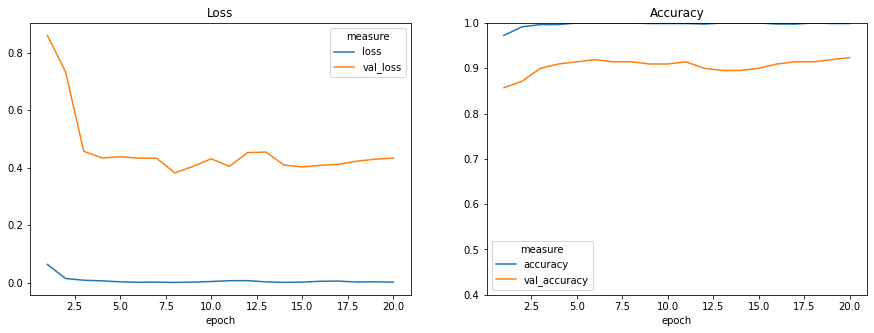

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

f, axis = plt.subplots(1,2, figsize = (15,5))

ax1 = sns.lineplot(x = 'epoch',
                   y = 'value',
                   hue = 'measure',
                   data = mobilenet_history_stacked[mobilenet_history_stacked['metric'] == 'loss'],
                   ax = axis[0])
ax1.set(title = 'Loss', ylabel = '')
ax2 = sns.lineplot(x = 'epoch',
                   y = 'value',
                   hue = 'measure',
                   data = mobilenet_history_stacked[mobilenet_history_stacked['metric'] == 'accuracy'],
                   ax = axis[1])
ax2.set(ylim = (0.4, 1), title = 'Accuracy', ylabel = '')
plt.show()

Modificando l'optimizer si ottengono risultati molto piu soddisfacenti

#Tuning

Configuazioni per il tuning

In [ ]:
optimizers_config = {
    'adam' : optimizers.Adam,
    'adamax' : optimizers.Nadam,
    'nadam' : optimizers.Adamax
    }
tuner_dir = 'tuner_mobilenet'
tuner_project = 'tuner_mobilenet'

In [ ]:
# modello
hyper_model = network(
        X_train.shape[1:],
        pre_trained = mobilenet,
        optimizers_config = optimizers_config
        )
    
# creazione del tuner
tuner = keras_tuner(
        hyper_model,
        objective = 'val_accuracy',
        seed = 15,
        max_trials = 50,
        directory = tuner_dir,
        project_name = tuner_project
        )

In [ ]:
# avvio la ricerca
tuner.search(
        X_train, y_train,
        epochs = 30,
        validation_data = (X_val, y_valid),
        callbacks = [callbacks.EarlyStopping(patience = 4)]
        )

Trial 50 Complete [00h 00m 14s]
val_accuracy: 0.8619047403335571

Best val_accuracy So Far: 0.9333333373069763
Total elapsed time: 00h 22m 15s
INFO:tensorflow:Oracle triggered exit


In [ ]:
shutil.make_archive('tuner_mobilenet', 'zip', 'tuner_mobilenet')
shutil.copyfile(
    'tuner_mobilenet.zip',
    '/content/gdrive/MyDrive/DSIM/image_classification/tuner_mobilenet.zip'
    )

'/content/gdrive/MyDrive/DSIM/image_classification/tuner_mobilenet.zip'

### Risultati

In [ ]:
path_data = '/content/tuner_mobilenet/tuner_mobilenet/'
all_files = [os.path.join(path, name) for path, subdirs, files in os.walk(path_data) for name in files]
reg = re.compile(".*trial.json")
trials = [re.sub('\\\\', '/', x) for x in list(filter(reg.match, all_files))]

In [ ]:
# dataframe dei risultati del tuning per ogni configurazione
trials_list = []
for trial in trials:
    with open(trial, 'r') as f:
        current_file = json.load(f)
    trials_list.append(pd.DataFrame({
    'trial_id' : [current_file['trial_id']],
    'optimizer' : [current_file['hyperparameters']['values']['optimizer']],
    'learning_rate' : current_file['hyperparameters']['values']['learning_rate'],
    'epsilon' : current_file['hyperparameters']['values']['epsilon'],
    'batch_size' : current_file['hyperparameters']['values']['batch_size'],
    'dropout_rate' : current_file['hyperparameters']['values']['dropout_rate'],
    'loss' : current_file['metrics']['metrics']['loss']['observations'][0]['value'],
    'accuracy' : current_file['metrics']['metrics']['accuracy']['observations'][0]['value'],
    'val_loss' : current_file['metrics']['metrics']['val_loss']['observations'][0]['value'],
    'val_accuracy' : current_file['metrics']['metrics']['val_accuracy']['observations'][0]['value']
}))

In [ ]:
trials_data = pd.concat(trials_list).reset_index(drop = True)
trials_data['loss'] = trials_data['loss'].apply(lambda x : 0 if x == float('+inf') else x)
trials_data['val_loss'] = trials_data['val_loss'].apply(lambda x : 0 if x == float('+inf') else x)
trials_data.to_csv(path_data + 'all_trials.csv', index = False)
trials_data.sort_values('val_accuracy', ascending = False).head()

,trial_id,optimizer,learning_rate,epsilon,batch_size,dropout_rate,loss,accuracy,val_loss,val_accuracy
27,c7ea02f483e0b981f45edb760c3d0ecb,nadam,0.000704,1.037733e-07,128,0.2,0.509871,1.0,0.269017,0.933333
16,d5b65d15c2d64034acc3d204be84f71c,nadam,0.000687,1.144167e-07,64,0.8,0.409424,1.0,0.411321,0.928571
3,38f225632bdcb313d38d1a2d85875b70,nadam,0.001363,8.565458e-08,32,0.7,0.042639,1.0,0.591979,0.928571
30,251759b7f6d48e481dfa7e10100b0ef5,adam,0.000800,1.428312e-07,64,0.8,0.367189,1.0,1.831912,0.928571
44,91ee17f9cce583324c9a4167676c6a8e,nadam,0.000881,9.675917e-08,64,0.1,0.163537,1.0,0.319333,0.928571


I risultati migliori si ottengono utilizzando come ottimizzatore Nadam (lr = 0.000704, eps = 1.037733e-07), una batch size di 128 e un dropout rate di 0.2.

In [ ]:
trials_data.to_pickle('tuning_results.df')
shutil.copyfile(
    'tuning_results.df',
    '/content/gdrive/MyDrive/DSIM/image_classification/tuning_results.df'
    )

'/content/gdrive/MyDrive/DSIM/image_classification/tuning_results.df'

Learning curve del best trial

In [ ]:
best_trial = trials_data.sort_values('val_accuracy', ascending = False)['trial_id'].iloc[0]
learning_curves = pd.read_csv(
    path_data + best_trial + '.txt',
    names = ['epoch', 'timestamp', 'train_loss', 'val_loss', 'train_accuracy', 'val_accuracy']
)

learning_curves.head()

,epoch,timestamp,train_loss,val_loss,train_accuracy,val_accuracy
0,0,2021-02-16 09:44:51.572062,0.509871,0.257096,0.827381,0.933333
1,1,2021-02-16 09:44:54.082541,0.005730,0.260988,1.000000,0.933333
2,2,2021-02-16 09:44:56.443441,0.002649,0.265934,1.000000,0.933333
3,3,2021-02-16 09:44:58.821856,0.002250,0.268168,1.000000,0.933333
4,4,2021-02-16 09:45:01.191531,0.001814,0.269017,1.000000,0.933333


# Modello finale

Costruzione del modello finale usando gli iperparametri vincenti

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
final_model = tuner.hypermodel.build(best_hps)
history = final_model.fit(
    X_train, y_train,
    validation_data = (X_val, y_valid),
    epochs = 30,
    callbacks = [callbacks.EarlyStopping(patience = 4)],
    batch_size = 128
    )

Epoch 1/30
7/7 [==============================] - 5s 411ms/step - loss: 1.3059 - accuracy: 0.5041 - val_loss: 0.5672 - val_accuracy: 0.7143
Epoch 2/30
7/7 [==============================] - 2s 339ms/step - loss: 0.0247 - accuracy: 1.0000 - val_loss: 0.4669 - val_accuracy: 0.8048
Epoch 3/30
7/7 [==============================] - 2s 339ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.4077 - val_accuracy: 0.8333
Epoch 4/30
7/7 [==============================] - 2s 339ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.3668 - val_accuracy: 0.8619
Epoch 5/30
7/7 [==============================] - 2s 342ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.3380 - val_accuracy: 0.8857
Epoch 6/30
7/7 [==============================] - 2s 340ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.3169 - val_accuracy: 0.8905
Epoch 7/30
7/7 [==============================] - 2s 342ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.3004 - val_accuracy: 0.9048
Epoch 8/30
7/7 [====

In [ ]:
K.clear_session()
mobilenet = applications.MobileNet((224,224,3),include_top=False, pooling='avg')
cut = 'conv_dw_6_relu'
mobilenet_pre_trained = Model(
    mobilenet.input,
    outputs = mobilenet.get_layer(cut).output,
    name = 'pre_trained')

Modello finale ottenuto dalla concatenazione di quello pre-addestrato (e congelato) e la parte finale della CNN

In [ ]:
model = Sequential(
    [
      mobilenet_pre_trained,
      final_model
     ]
)

model.compile(metrics = 'accuracy')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pre_trained (Functional)     (None, 14, 14, 256)       140480    
_________________________________________________________________
model (Functional)           (None, 3)                 3091459   
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________


In [ ]:
model.save('final_model_image_classification')

INFO:tensorflow:Assets written to: final_model_image_classification/assets


In [ ]:
shutil.make_archive('final_model_image_classification', 'zip', 'final_model_image_classification')
shutil.copyfile(
    'final_model_image_classification.zip',
    '/content/gdrive/MyDrive/DSIM/image_classification/final_model_image_classification.zip'
    )

'/content/gdrive/MyDrive/DSIM/image_classification/final_model_image_classification.zip'

Memorizzazione della codifica delle labels

In [ ]:
map_classes = {}
for label in train_generator.class_indices:
  map_classes[train_generator.class_indices[label]] = label
map_classes

{0: 'defocused_blurred', 1: 'motion_blurred', 2: 'sharp'}

In [ ]:
with open('map_classes.pkl', 'wb') as f:
  pickle.dump(map_classes, f)

In [ ]:
shutil.copyfile(
    'map_classes.pkl',
    '/content/gdrive/MyDrive/DSIM/image_classification/map_classes.pkl'
    )

'/content/gdrive/MyDrive/DSIM/image_classification/map_classes.pkl'